In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [2]:
import kwant
print(kwant.version.version)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import scipy as spi
import scipy.constants as const
import scipy.optimize as op
import scipy.misc as misc
plt.rcParams.update({'font.size': 20})

#constants
hbar = const.hbar
m_e = const.m_e
eV = const.e
print(eV)

1.4.2
1.602176634e-19


In [3]:
tau_0 = np.kron(np.eye(2), np.eye(2))
tau_x = np.kron(np.array([[0, 1], [1, 0]]), np.eye(2))
tau_y = np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2))
tau_z = np.kron(np.array([[1, 0], [0, -1]]), np.eye(2))
sigma_0 = np.kron(np.eye(2), np.eye(2))
sigma_x = np.kron(np.eye(2), np.array([[0, 1], [1, 0]]))
sigma_y = np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]]))
sigma_z = np.kron(np.eye(2), np.array([[1, 0], [0, -1]]))
t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
b_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
d_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
print(tau_z@sigma_0-tau_0@sigma_z)
print(tau_0@sigma_0-tau_z@sigma_z)
print(t_z)
print(b_z)
print(d_z)

[[ 0.  0.  0.  0.]
 [ 0.  2.  0.  0.]
 [ 0.  0. -2.  0.]
 [ 0.  0.  0.  0.]]
[[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1. -0. -0. -0.]
 [ 0.  0.  0.  0. -0. -1. -0. -0.]
 [ 0.  0.  0.  0. -0. -0. -1. -0.]
 [ 0.  0.  0.  0. -0. -0. -0. -1.]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1. -0.  0.  0. -0. -0.]
 [ 0.  0. -0. -1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0. -0.  0.  0. -1. -0.]
 [ 0.  0. -0. -0.  0.  0. -0. -1.]]
[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -0.  0. -0.  0. -0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0. -0.  0. -1.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0. -0.  0. -0.  0. -1.  0. -0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0. -0.  0. -0.  0. -0.  0. -1.]]


0.35355339059327373
0.35355339059327373


Text(0, 0.5, '$E$ (meV)')

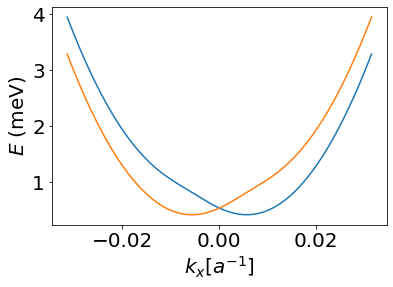

In [4]:
def dispersion(k_x, j, m_star=0.023, W_nm=140, alpha_meVnm=35):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    #print(alpha)
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    print(eta/eV*1000.)
    #print(E_2_perp/eV*1000)
    #print((E_2_perp - E_1_perp)/eV*1000.)
    #print((E_1_perp-E_2_perp)/(2.*(-1.)**j*alpha)*6.0583e-10)
    return ((hbar*k_x)**2./(2.*m_star*m_e) + (E_1_perp+E_2_perp)/2. - np.sqrt((((E_1_perp-E_2_perp)/2.)+(-1.)**j*alpha*k_x)**2.+eta**2.))/eV*1000.

a = 6.0583e-10
k_x = np.linspace(-np.pi/a/100, np.pi/a/100, 200)
E_1 = dispersion(k_x, 1, 0.023, 140, 35)
E_2 = dispersion(k_x, 2, 0.023, 140, 35)
k_x_in_right_unit = np.linspace(-np.pi/100, np.pi/100, 200)
plt.plot(k_x_in_right_unit, E_1)
plt.plot(k_x_in_right_unit, E_2)
plt.xlabel(r'$k_x[a^{-1}]$')
plt.ylabel(r'$E$ (meV)')

0.35355339059327373
0.35355339059327373
here
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.4055872464882865
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327

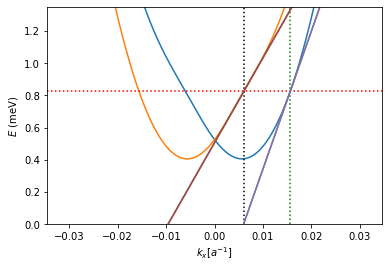

In [8]:
#functions to calculate parameters:
def dispersion(k_x, j, m_star=0.023, W_nm=140, alpha_meVnm=35):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    #print(alpha)
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    print(eta/eV*1000.)
    #print(E_2_perp/eV*1000)
    #print((E_2_perp - E_1_perp)/eV*1000.)
    #print((E_1_perp-E_2_perp)/(2.*(-1.)**j*alpha)*6.0583e-10)
    return ((hbar*k_x)**2./(2.*m_star*m_e) + (E_1_perp+E_2_perp)/2. - np.sqrt((((E_1_perp-E_2_perp)/2.)+(-1.)**j*alpha*k_x)**2.+eta**2.))/eV*1000.

a = 6.0583e-10
k_x = np.linspace(-np.pi/a/100, np.pi/a/100, 200)
E_1 = dispersion(k_x, 1, 0.023, 140, 35)
E_2 = dispersion(k_x, 2, 0.023, 140, 35)
k_x_in_right_unit = np.linspace(-np.pi/100, np.pi/100, 200)
plt.plot(k_x_in_right_unit, E_1)
plt.plot(k_x_in_right_unit, E_2)
plt.xlabel(r'$k_x[a^{-1}]$')
plt.ylabel(r'$E$ (meV)')
print('here')
print(op.minimize_scalar(lambda k_x: dispersion(k_x, 1)).fun)
plt.axhline(op.minimize_scalar(lambda k_x: dispersion(k_x, 1)).fun+0.422, ls=':', c='r')
plt.axvline(k_F_given_mu(1)*a, ls=':', c='g')
plt.axvline(k_F_given_mu(2)*a, ls=':', c='k')
plt.ylim(0, 1.35)
grad1 = (misc.derivative(lambda k_x: dispersion(k_x, 1)*eV/1000., k_F_given_mu(1)))*1000./eV
grad2 = (misc.derivative(lambda k_x: dispersion(k_x, 2)*eV/1000., k_F_given_mu(2)))*1000./eV
grad3 = v_F_given_mu()[0]*hbar*1000/eV
grad4 = v_F_given_mu()[1]*hbar*1000/eV
print('v1:')
print(grad1*eV/1000./hbar)
print('v2:')
print(grad2*eV/1000./hbar)
def linear_func(k_x, k_0, E_0, grad):
    return E_0+grad*(k_x-k_0)
plt.plot(k_x*a, linear_func(k_x, k_F_given_mu(1), dispersion(k_F_given_mu(1), 1), grad1))
plt.plot(k_x*a, linear_func(k_x, k_F_given_mu(2), dispersion(k_F_given_mu(2), 2), grad2))
plt.plot(k_x*a, linear_func(k_x, k_F_given_mu(1), dispersion(k_F_given_mu(1), 1), grad3))
plt.plot(k_x*a, linear_func(k_x, k_F_given_mu(2), dispersion(k_F_given_mu(2), 2), grad4))
print('lowest')
print(np.min(E_1))
print(op.minimize_scalar(lambda k_x: dispersion(k_x, 1)).fun)

In [5]:
def k_F_given_mu(j, m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.422):
    band_bottom = op.minimize_scalar(lambda k_x: dispersion(k_x, j)).fun
    def func(k_x):
        return dispersion(k_x, j, m_star, W_nm, alpha_meVnm)-mu_meV-band_bottom
    k_F = op.brentq(func, 0, 0.03/a)
    return k_F

def v_F_given_mu(m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=0.422):
    alpha = alpha_meVnm*eV*1e-12
    W = W_nm*1e-9
    E_1_perp = (4*hbar**2.)/(m_star*m_e*W**2.)
    E_2_perp = (8*hbar**2.)/(m_star*m_e*W**2.)
    eta = np.sqrt(2)*alpha/W
    
    k_F1 = k_F_given_mu(1, m_star, W_nm, alpha_meVnm, a, mu_meV)
    k_F2 = k_F_given_mu(2, m_star, W_nm, alpha_meVnm, a, mu_meV)
    
    #print(k_F1-k_F2-2.*m_star*m_e*alpha/hbar**2.)
    
    v_1 = hbar*k_F1/(m_star*m_e) + (-1)**1*(alpha*((E_1_perp/2.)-(-1)**1*alpha*k_F1))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**1*alpha*k_F1)**2. + eta**2.))
    v_2 = hbar*k_F2/(m_star*m_e) + (-1)**2*(alpha*((E_1_perp/2.)-(-1)**2*alpha*k_F2))/(hbar*np.sqrt(((E_1_perp/2.)-(-1.)**2*alpha*k_F2)**2. + eta**2.))
    
    #print(v_1-v_2)
    return np.array([v_1, v_2])

print(v_F_given_mu())

0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373


In [7]:
def v_k_given_mu(m_star=0.023, W_nm=140, alpha_meVnm=35, a=6.0583e-10, mu_meV=1.):
    k_F1 = k_F_given_mu(1, m_star, W_nm, alpha_meVnm, a, mu_meV)
    k_F2 = k_F_given_mu(2, m_star, W_nm, alpha_meVnm, a, mu_meV)
    v_1, v_2 = v_F_given_mu(m_star, W_nm, alpha_meVnm, a, mu_meV)
    
    v_plus = 0.5*(v_1+v_2)
    v_minus = 0.5*(v_1-v_2)
    k_plus = 0.5*(v_1*k_F1+v_2*k_F2)
    k_minus = 0.5*(v_1*k_F1-v_2*k_F2)
    return np.array([v_plus, v_minus, k_plus, k_minus])
    
print(v_k_given_mu())

0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373
0.35355339059327373


In [16]:
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def make_system(L=370, W=140):
    norbs = 4 # 4 orbitals (2 for particle-hole x 2 for spins)
    ham_rashba = ("hbar**2/(2*m_star*m_e)*(k_x**2+k_y**2+k_z**2) * kron(sigma_z, sigma_0) +"
                 "hbar**2/(2*m_star*m_e*(W/2)**4)*(y**2+z**2) * kron(sigma_z, sigma_0) +"
                 "alpha*(-k_x*kron(sigma_z, sigma_y)+k_y*kron(sigma_z, sigma_x)) +"
                 "B * kron(sigma_z, sigma_x)")
    
    ham_discr, coords = kwant.continuum.discretize_symbolic(ham_rashba)
    print(ham_discr)
    
    a = 6.0583e-1*50
    rashba_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
    
    ## system creation
    syst_rashba = kwant.Builder()
    _ = syst_rashba.fill(rashba_syst, *get_shape(L, W, W))

    lat = kwant.lattice.chain(a, norbs=norbs)
    
    return syst_rashba.finalized()
    
make_system()
    

{(0, 0, 0): Matrix([
[hbar**2/(a_z**2*m_e*m_star) + hbar**2/(a_y**2*m_e*m_star) + hbar**2/(a_x**2*m_e*m_star) + 8*hbar**2*y**2/(W**4*m_e*m_star) + 8*hbar**2*z**2/(W**4*m_e*m_star),                                                                                                                                                             B,                                                                                                                                                              0,                                                                                                                                                              0],
[                                                                                                                                                            B, hbar**2/(a_z**2*m_e*m_star) + hbar**2/(a_y**2*m_e*m_star) + hbar**2/(a_x**2*m_e*m_star) + 8*hbar**2*y**2/(W**4*m_e*m_star) + 8*hbar**2*z**2/(W**4*m_e*m_star),                     

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [38]:
#functions in kwant.continuum
def re(x):
    return np.real(x)

def im(x):
    return np.imag(x)

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

def make_system(L_x=100, W_y=100, H_z=100):
    
    ## kwant.continuum for setting up system hamiltonians
    norbs = 8 # 8 orbitals (2 for particle-hole x 2 for subband x 2 for spin)
    ham_TI = ("t_prime * k_x**2 * kron(sigma_z, sigma_0, sigma_0) +"
              "E_plus * kron(sigma_z, sigma_0, sigma_0) +"
              "E_minus * kron(sigma_z, sigma_z, sigma_0) -"
              "mu * kron(sigma_z, sigma_0, sigma_0) -"
              "alpha * k_x * kron(sigma_z, sigma_0, sigma_y) +"
              "eta * kron(sigma_z, sigma_y, sigma_x) +"
              "B_prime * kron(sigma_z, sigma_0, sigma_x)")


    SC_final0 = ("+ delta * cosphi * kron(sigma_x, sigma_0, sigma_0) -"
                  "delta * sinphi * kron(sigma_y, sigma_0, sigma_0)")
    
    SC_final1 = ("+ delta * cosphi * kron(sigma_x, sigma_0, sigma_0) -"
                  "delta * sinphi * kron(sigma_y, sigma_0, sigma_0)")

    ham_TI_SC0 = ham_TI + SC_final0 # 3D TI BdG Hamiltonian with superconducting pairing potential

    ham_TI_SC1 = ham_TI + SC_final1

    ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)
    
    ham_discr_lead0, coords_lead0 = kwant.continuum.discretize_symbolic(ham_TI_SC0)

    ham_discr_lead1, coords_lead1 = kwant.continuum.discretize_symbolic(ham_TI_SC1)
    
    print('scattering region')
    print(ham_discr)
    
    print('leads')
    print(ham_discr_lead0)
    
    ## discretise exprs
    a = 10
    ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
    ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead0, coords_lead0, grid=a)
    ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead1, coords_lead1, grid=a)
    
    
    
    ## system creation
    syst_TI = kwant.Builder()
    _ = syst_TI.fill(ti_syst, *get_shape(L_x, W_y, H_z))

    lat = kwant.lattice.cubic(a, norbs=norbs)
    
    ## leads
    lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0))#,
    #                        conservation_law=conservation_law,
    #                        particle_hole=particle_hole,
    #                        time_reversal=time_reversal
                          )
    lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0))#,
    #                        conservation_law=conservation_law,
    #                        particle_hole=particle_hole,
    #                        time_reversal=time_reversal
                          )

    lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
    lead_1.fill(ti_lead_1, *get_shape_lead_0(L_x, W_y, H_z))

    syst_TI.attach_lead(lead_0)
    syst_TI.attach_lead(lead_1)
    
    return syst_TI.finalized()

In [39]:
make_system()

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.W

scattering region
{(0,): Matrix([
[E_minus + E_plus - mu + 2*t_prime/a_x**2,                                  B_prime,                                         0,                                    -I*eta,                                         0,                                         0,                                        0,                                        0],
[                                 B_prime, E_minus + E_plus - mu + 2*t_prime/a_x**2,                                    -I*eta,                                         0,                                         0,                                         0,                                        0,                                        0],
[                                       0,                                    I*eta, -E_minus + E_plus - mu + 2*t_prime/a_x**2,                                   B_prime,                                         0,                                         0,                          

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


ValueError: Shape mismatch: a and b should have the same number of rows (1 != 3).

/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/Users/afasjasd/anaconda3/envs/snakes/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


{(0, 0, 0): Matrix([
[hbar**2/(a_z**2*m_e*m_star) + hbar**2/(a_y**2*m_e*m_star) + hbar**2/(a_x**2*m_e*m_star) + 8*hbar**2*y**2/(W**4*m_e*m_star) + 8*hbar**2*z**2/(W**4*m_e*m_star),                                                                                                                                                             B,                                                                                                                                                              0,                                                                                                                                                              0],
[                                                                                                                                                            B, hbar**2/(a_z**2*m_e*m_star) + hbar**2/(a_y**2*m_e*m_star) + hbar**2/(a_x**2*m_e*m_star) + 8*hbar**2*y**2/(W**4*m_e*m_star) + 8*hbar**2*z**2/(W**4*m_e*m_star),                     

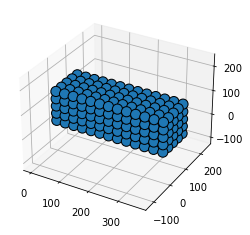

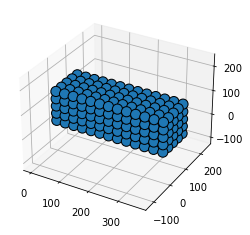

In [237]:
kwant.plot(make_system())

In [ ]:
#Test 1:
#E_2_perp - E_1_perp ~ 0.68meV
#putting W=140nm and m*=0.023m_0 gives E_2_perp - E_1_perp = 0.6761281483859556 meV

def make_system(L=370):
    norbs = 8 # 8 orbitals (2 for particle-hole x 2 for subbands x 2 for right/left-moving particles)
    ham_TI = ("- mu * kron(sigma_z, sigma_0, sigma_0) + "
              "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
              "{M} * kron(sigma_z, sigma_0, sigma_z) - "
              "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
              "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
              "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
              "m_z * kron(sigma_z, sigma_z, sigma_0)") # magnetization term for MTI

    ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)

In [3]:
#functions in kwant.continuum
def re(x):
    return np.real(x)

def im(x):
    return np.imag(x)

# shape of system
def get_shape(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= x <= L and 0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

# shape of leads
def get_shape_lead_0(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([0, 0, 0])

def get_shape_lead_1(L, W, H):
    def shape(site):
        (x, y, z) = site.pos
        return (0 <= y <= W and 0 <= z <= H)
    return shape, np.array([L, 0, 0])

def make_system(L_x=100, W_y=100, H_z=100):
    
    ## kwant.continuum for setting up system hamiltonians
    norbs = 8 # 8 orbitals (2 for particle-hole x 2 for spin up-down x 2 for orbitals A/B)
    ham_TI = ("- mu * kron(sigma_z, sigma_0, sigma_0) + "
              "{epsilon} * kron(sigma_z, sigma_0, sigma_0) + "
              "{M} * kron(sigma_z, sigma_0, sigma_z) - "
              "A_perp * k_x * kron(sigma_z, sigma_y, sigma_x) + "
              "A_perp * k_y * kron(sigma_0, sigma_x, sigma_x) + "
              "A_z * k_z * kron(sigma_z, sigma_0, sigma_y) + "
              "m_z * kron(sigma_z, sigma_z, sigma_0)") # magnetization term for MTI


    epsilon = "(C_0 - C_perp * (k_x**2 + k_y**2) - C_z * k_z**2)"
    M = "(M_0 - M_perp * (k_x**2 + k_y**2) - M_z * k_z**2)"
    ham_TI = ham_TI.format(epsilon=epsilon, M=M)
    ham_TI = ham_TI.format(C_0="C_0")


    SC_complex = ("- re({Delta}) * kron(sigma_y, sigma_y, sigma_0) -"
                  "im({Delta}) * kron(sigma_x, sigma_y, sigma_0)")

    SC_final0 = SC_complex.format(Delta="Deltaf0(y, z)")

    SC_final1 = SC_complex.format(Delta="Deltaf1(y, z)")

    ham_TI_SC0 = ham_TI + SC_final0 # 3D TI BdG Hamiltonian with superconducting pairing potential

    ham_TI_SC1 = ham_TI + SC_final1

    ham_discr, coords = kwant.continuum.discretize_symbolic(ham_TI)

    ham_discr_lead0, coords_lead0 = kwant.continuum.discretize_symbolic(ham_TI_SC0)

    ham_discr_lead1, coords_lead1 = kwant.continuum.discretize_symbolic(ham_TI_SC1)
    
    ## discretise exprs
    a = 10
    ti_syst = kwant.continuum.build_discretized(ham_discr, coords, grid=a)
    ti_lead_0 = kwant.continuum.build_discretized(ham_discr_lead0, coords_lead0, grid=a)
    ti_lead_1 = kwant.continuum.build_discretized(ham_discr_lead1, coords_lead1, grid=a)
    
    ## system creation
    syst_TI = kwant.Builder()
    _ = syst_TI.fill(ti_syst, *get_shape(L_x, W_y, H_z))

    lat = kwant.lattice.cubic(a, norbs=norbs)
    
    ## leads
    lead_0 = kwant.Builder(kwant.TranslationalSymmetry((-a, 0, 0))#,
    #                        conservation_law=conservation_law,
    #                        particle_hole=particle_hole,
    #                        time_reversal=time_reversal
                          )
    lead_1 = kwant.Builder(kwant.TranslationalSymmetry((a, 0, 0))#,
    #                        conservation_law=conservation_law,
    #                        particle_hole=particle_hole,
    #                        time_reversal=time_reversal
                          )

    lead_0.fill(ti_lead_0, *get_shape_lead_0(L_x, W_y, H_z))
    lead_1.fill(ti_lead_1, *get_shape_lead_0(L_x, W_y, H_z))

    syst_TI.attach_lead(lead_0)
    syst_TI.attach_lead(lead_1)
    
    return syst_TI.finalized()